In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import cv2

In [2]:
# Assuming the BUSI dataset is structured in subfolders for each class
data_dir = "BUSI"
categories = [f.name for f in os.scandir(data_dir) if f.is_dir()]
print("Classes in the BUSI dataset:")
for folder in categories:
    print(folder)

Classes in the BUSI dataset:
benign
malignant
normal


In [3]:
# Load and preprocess the images
images = []
labels = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_array = cv2.resize(img_array, (224, 224))  
        images.append(img_array)
        labels.append(class_num)

images = np.array(images)
labels = np.array(labels)

In [4]:
# Split the dataset into train and test sets
num_samples, height, width, channels = images.shape
X_flat = images.reshape(num_samples, -1)  # Reshape to (samples, height*width*channels)
X_train, X_test, y_train, y_test = train_test_split(X_flat, labels, test_size=0.25, random_state=42)
X_train = X_train.reshape(-1, 224, 224, 3)  # Reshape your input data to match the expected input shape

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=5,  # Rotate images by a maximum of 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    zoom_range=0.1,  # Zoom images by 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True
)

In [6]:
train_datagen.fit(X_train)
augmented_images = []
augmented_labels = []

# Number of times to augment the data (in this case, we'll double the dataset)
augmentation_factor = 2
for x_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=len(X_train), shuffle=False):
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) >= augmentation_factor:
        break

# Concatenate the augmented data batches
X_train = np.concatenate(augmented_images)
y_train = np.concatenate(augmented_labels)

# Verify the shape of augmented data
print("Shape of augmented images:", X_train.shape)
print("Shape of augmented labels:", y_train.shape)
X_test= X_test.reshape(-1, 224, 224, 3)

Shape of augmented images: (1170, 224, 224, 3)
Shape of augmented labels: (1170,)


In [7]:
# One-hot encoding the labels
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential()

pretrained_model= ResNet50(include_top=False, input_shape=(224,224,3), pooling='max',classes=3, weights='imagenet')

model.add(pretrained_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#pretrained_model.trainable=False
for layer in pretrained_model.layers:
    layer.trainable = False
# Unfreeze the last few layers for fine-tuning(I achieved much better results adding this step)
for layer in pretrained_model.layers[-12:]:
    layer.trainable = True
    
optimizer= Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

In [10]:
# Train the model with augmented data
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'resnet50.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)

history = model.fit(np.array(X_train),
                         y_train,
                         batch_size = 32,
                         verbose = 1,
                         epochs = 50,
                         #validation_split = 0.1,
                         validation_data=(X_test, y_test),
                         shuffle = True,
                         callbacks=[checkpoint]
                         #callbacks=[reduce_lr]
                     )

model.load_weights(checkpoint_path)

Epoch 1/50


37/37 [==============================] - ETA: 0s - loss: 1.7012 - accuracy: 0.4043
Epoch 1: val_accuracy improved from -inf to 0.64286, saving model to resnet50.h5
37/37 [==============================] - 180s 5s/step - loss: 1.7012 - accuracy: 0.4043 - val_loss: 0.7860 - val_accuracy: 0.6429
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 1.2495 - accuracy: 0.5308
Epoch 2: val_accuracy did not improve from 0.64286
37/37 [==============================] - 129s 3s/step - loss: 1.2495 - accuracy: 0.5308 - val_loss: 0.9419 - val_accuracy: 0.5918
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 1.0331 - accuracy: 0.6137
Epoch 3: val_accuracy did not improve from 0.64286
37/37 [==============================] - 133s 4s/step - loss: 1.0331 - accuracy: 0.6137 - val_loss: 1.0061 - val_accuracy: 0.6173
Epoch 4/50
37/37 [==============================] - ETA: 0s - loss: 0.9113 - accuracy: 0.6615
Epoch 4: val_accuracy improved from 0.64286 to 0.

Epoch 28/50
37/37 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9940
Epoch 28: val_accuracy did not improve from 0.79592
37/37 [==============================] - 184s 5s/step - loss: 0.0257 - accuracy: 0.9940 - val_loss: 1.7284 - val_accuracy: 0.7908
Epoch 29/50
37/37 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9983
Epoch 29: val_accuracy did not improve from 0.79592
37/37 [==============================] - 184s 5s/step - loss: 0.0134 - accuracy: 0.9983 - val_loss: 1.9680 - val_accuracy: 0.7755
Epoch 30/50
37/37 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9966
Epoch 30: val_accuracy did not improve from 0.79592
37/37 [==============================] - 185s 5s/step - loss: 0.0164 - accuracy: 0.9966 - val_loss: 1.6501 - val_accuracy: 0.7755
Epoch 31/50
37/37 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9983
Epoch 31: val_accuracy did not improve from 0.79592
37/37 [===============

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test, verbose=1)

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print("Test Accuracy:", evaluation[1])

7/7 [==============================] - 28s 4s/step
Test Accuracy: 0.795918345451355


1/1 [==============================] - 1s 828ms/step


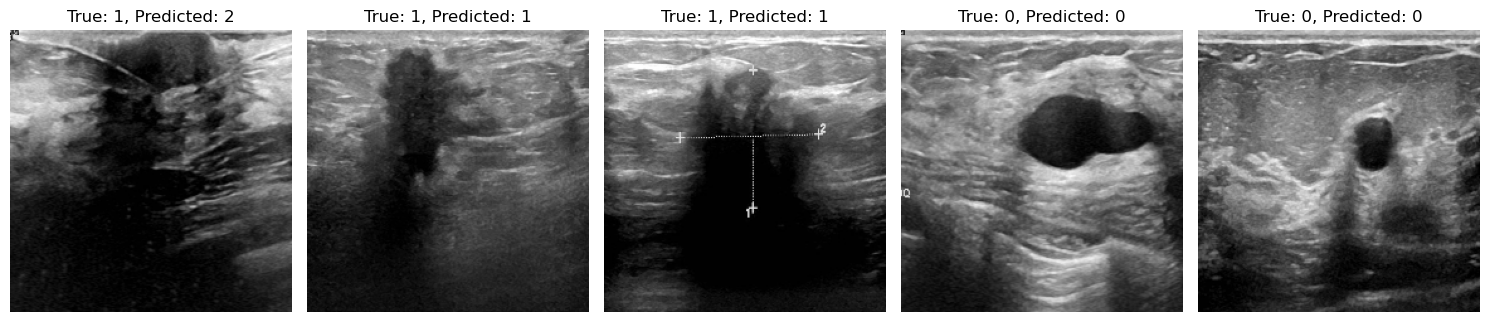

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Get some random indices from the test set
num_samples_to_display = 5  # Number of random samples to display
random_indices = np.random.choice(X_test.shape[0], num_samples_to_display, replace=False)

# Get the corresponding images, ground truth labels, and predicted labels
images_to_display = X_test[random_indices]
true_labels = y_test[random_indices]
predicted_labels = model.predict(images_to_display)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Convert true_labels to integers because they are one-hot encoded
true_labels_int = np.argmax(true_labels, axis=1)

# Display the images along with their ground truth and predicted labels
plt.figure(figsize=(15, 5))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images_to_display[i].reshape(height, width, channels))
    plt.title(f"True: {true_labels_int[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

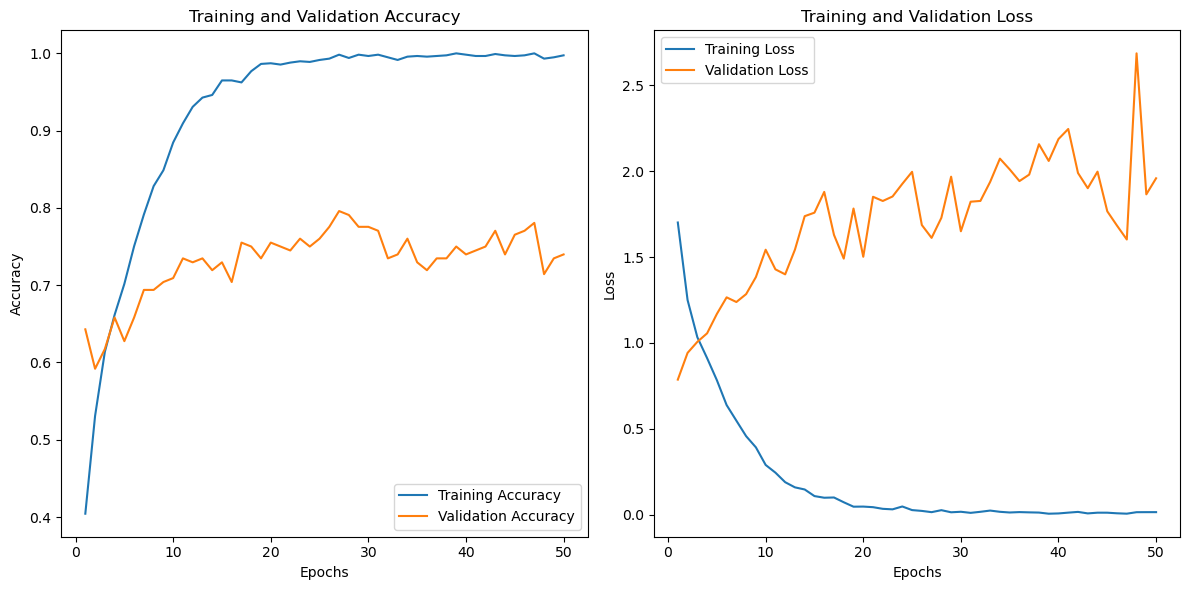

In [16]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
